In [203]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from rembg import remove

In [204]:
def resize_image(image, target_size):

    original_height, original_width, _ = image.shape
    target_width, target_height = target_size
    resized_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    
    for i in range(target_height):
        for j in range(target_width):
            original_x = int(j * original_width / target_width)
            original_y = int(i * original_height / target_height)
            resized_image[i, j] = image[original_y, original_x]
    
    return resized_image

In [205]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        for filename in tqdm(os.listdir(folder+label)):
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (350, 350))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [206]:
data, filenames,label, path, distribusi = insertGambar("selected_flower/") 
print("Data: ", len(data))
print("Label: ", len(label))
print("Filenames: ", len(filenames))
print("Data Distribution: ", distribusi)

Dendellion


100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Rose


100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


Sunflower


100%|██████████| 100/100 [00:11<00:00,  8.78it/s]

Data:  300
Label:  3
Filenames:  300
Data Distribution:  {'Dendellion': 100, 'Rose': 100, 'Sunflower': 100}


In [207]:
def displayImg(row, column, data):
    fig = plt.figure(figsize=(20, 20))
    for i in range(1, row*column +1):
        fig.add_subplot(row, column, i)
        plt.imshow(data[i-1], cmap='gray')
    plt.show()

In [208]:
def removeBackground(data):
    removed_data = []
    for i in tqdm(range(len(data))):
        removed_data.append(remove(data[i]))
    return removed_data

100%|██████████| 300/300 [15:17<00:00,  3.06s/it]


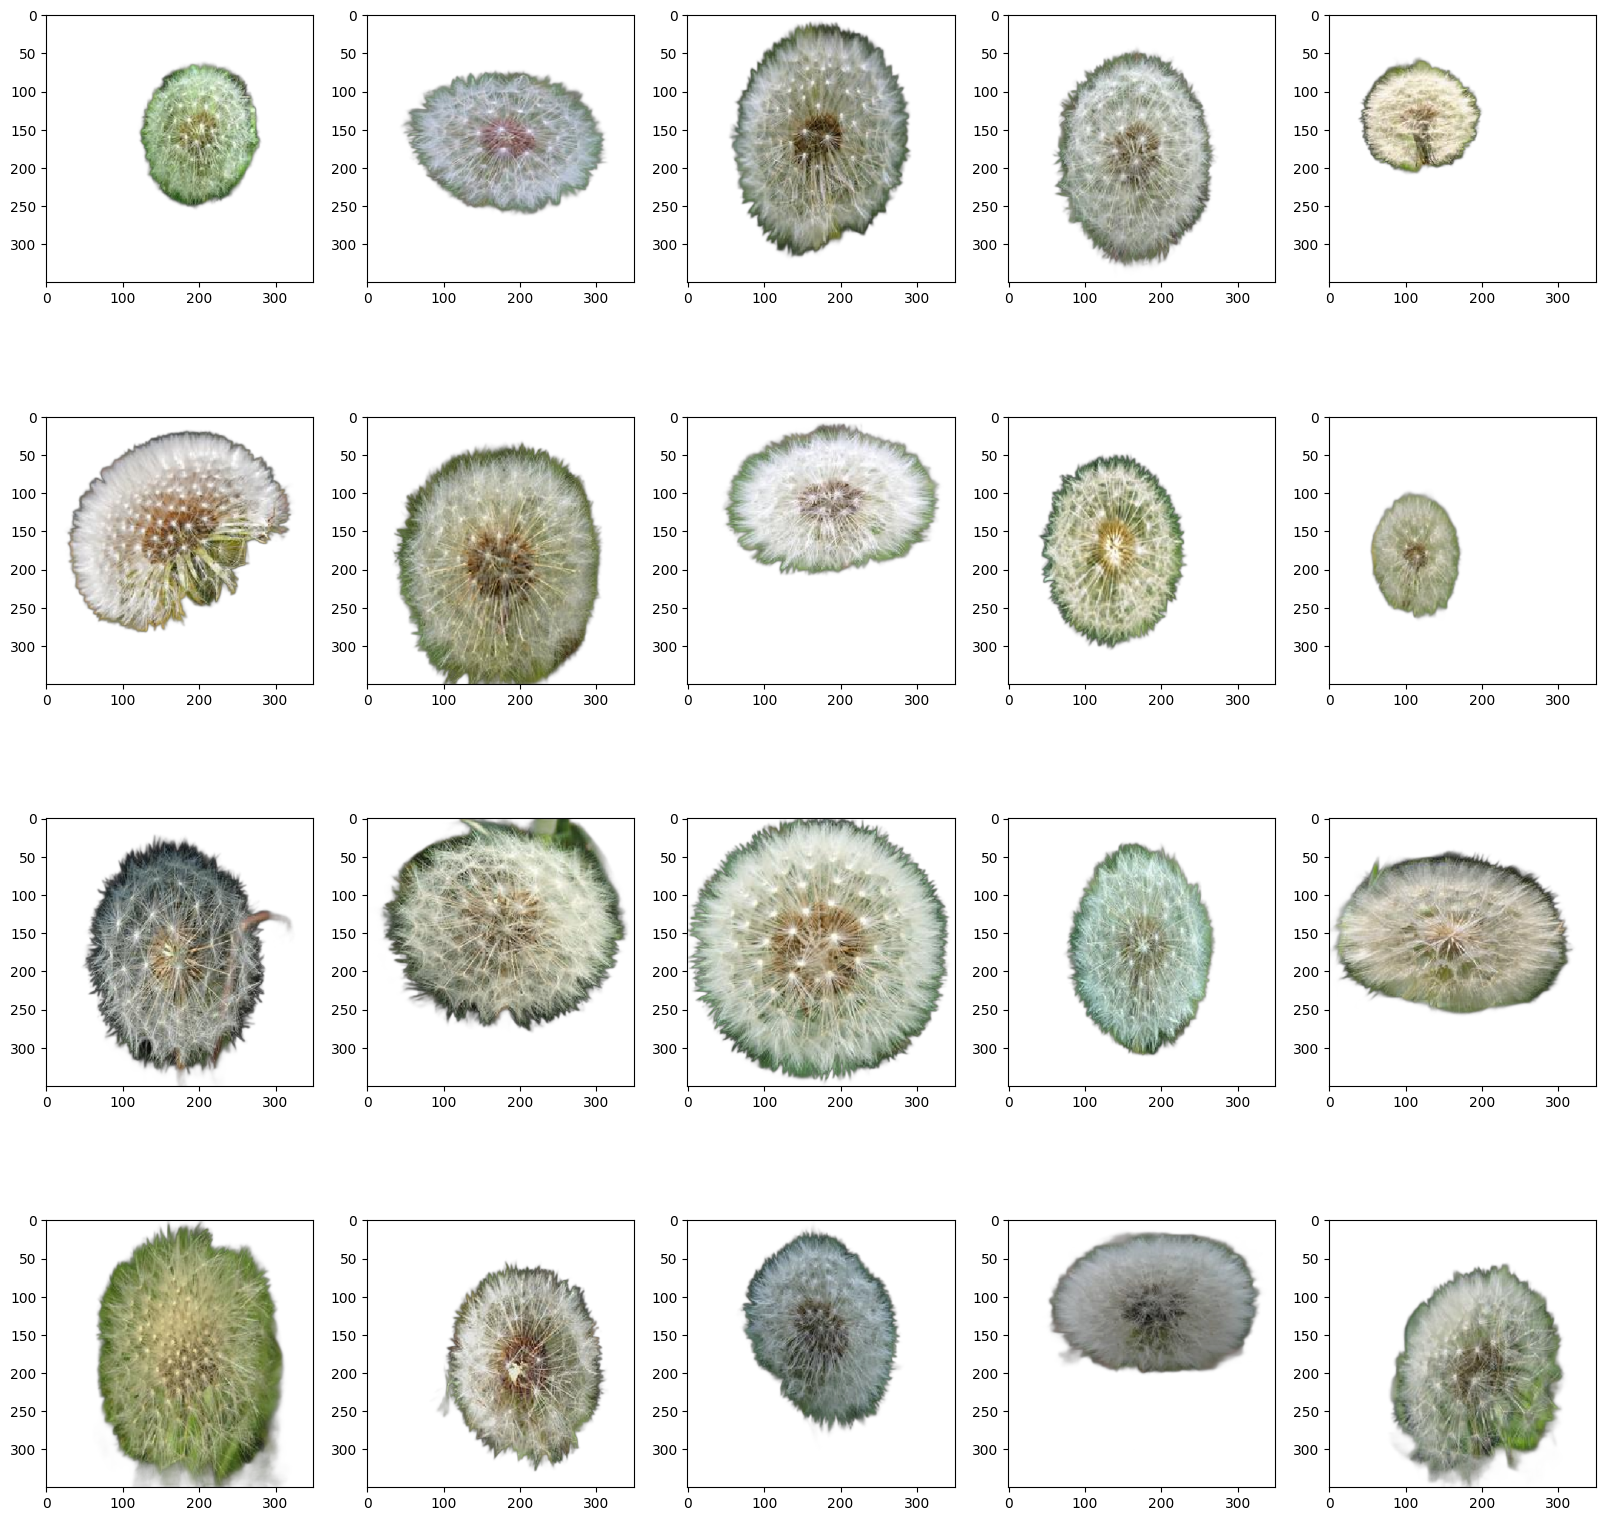

In [209]:
removed = removeBackground(data)
displayImg(4, 5, removed)

In [210]:
def grayScaling(img):
    gaussKernel = np.ones((3,3))/9
    r = img[:,:,2]
    g = img[:,:,1]
    b = img[:,:,0]
    filteredR = cv.filter2D(r,-1,gaussKernel)
    filteredG = cv.filter2D(g,-1,gaussKernel)
    filteredB = cv.filter2D(b,-1,gaussKernel)
    return np.round(filteredR/3 + filteredG/3 + filteredB/3).astype(np.uint8)

def grayScalingData(data):
    gray_data = []
    for i in tqdm(range(len(data))):
        gray_data.append(grayScaling(data[i]))
    return gray_data

100%|██████████| 300/300 [00:01<00:00, 194.78it/s]


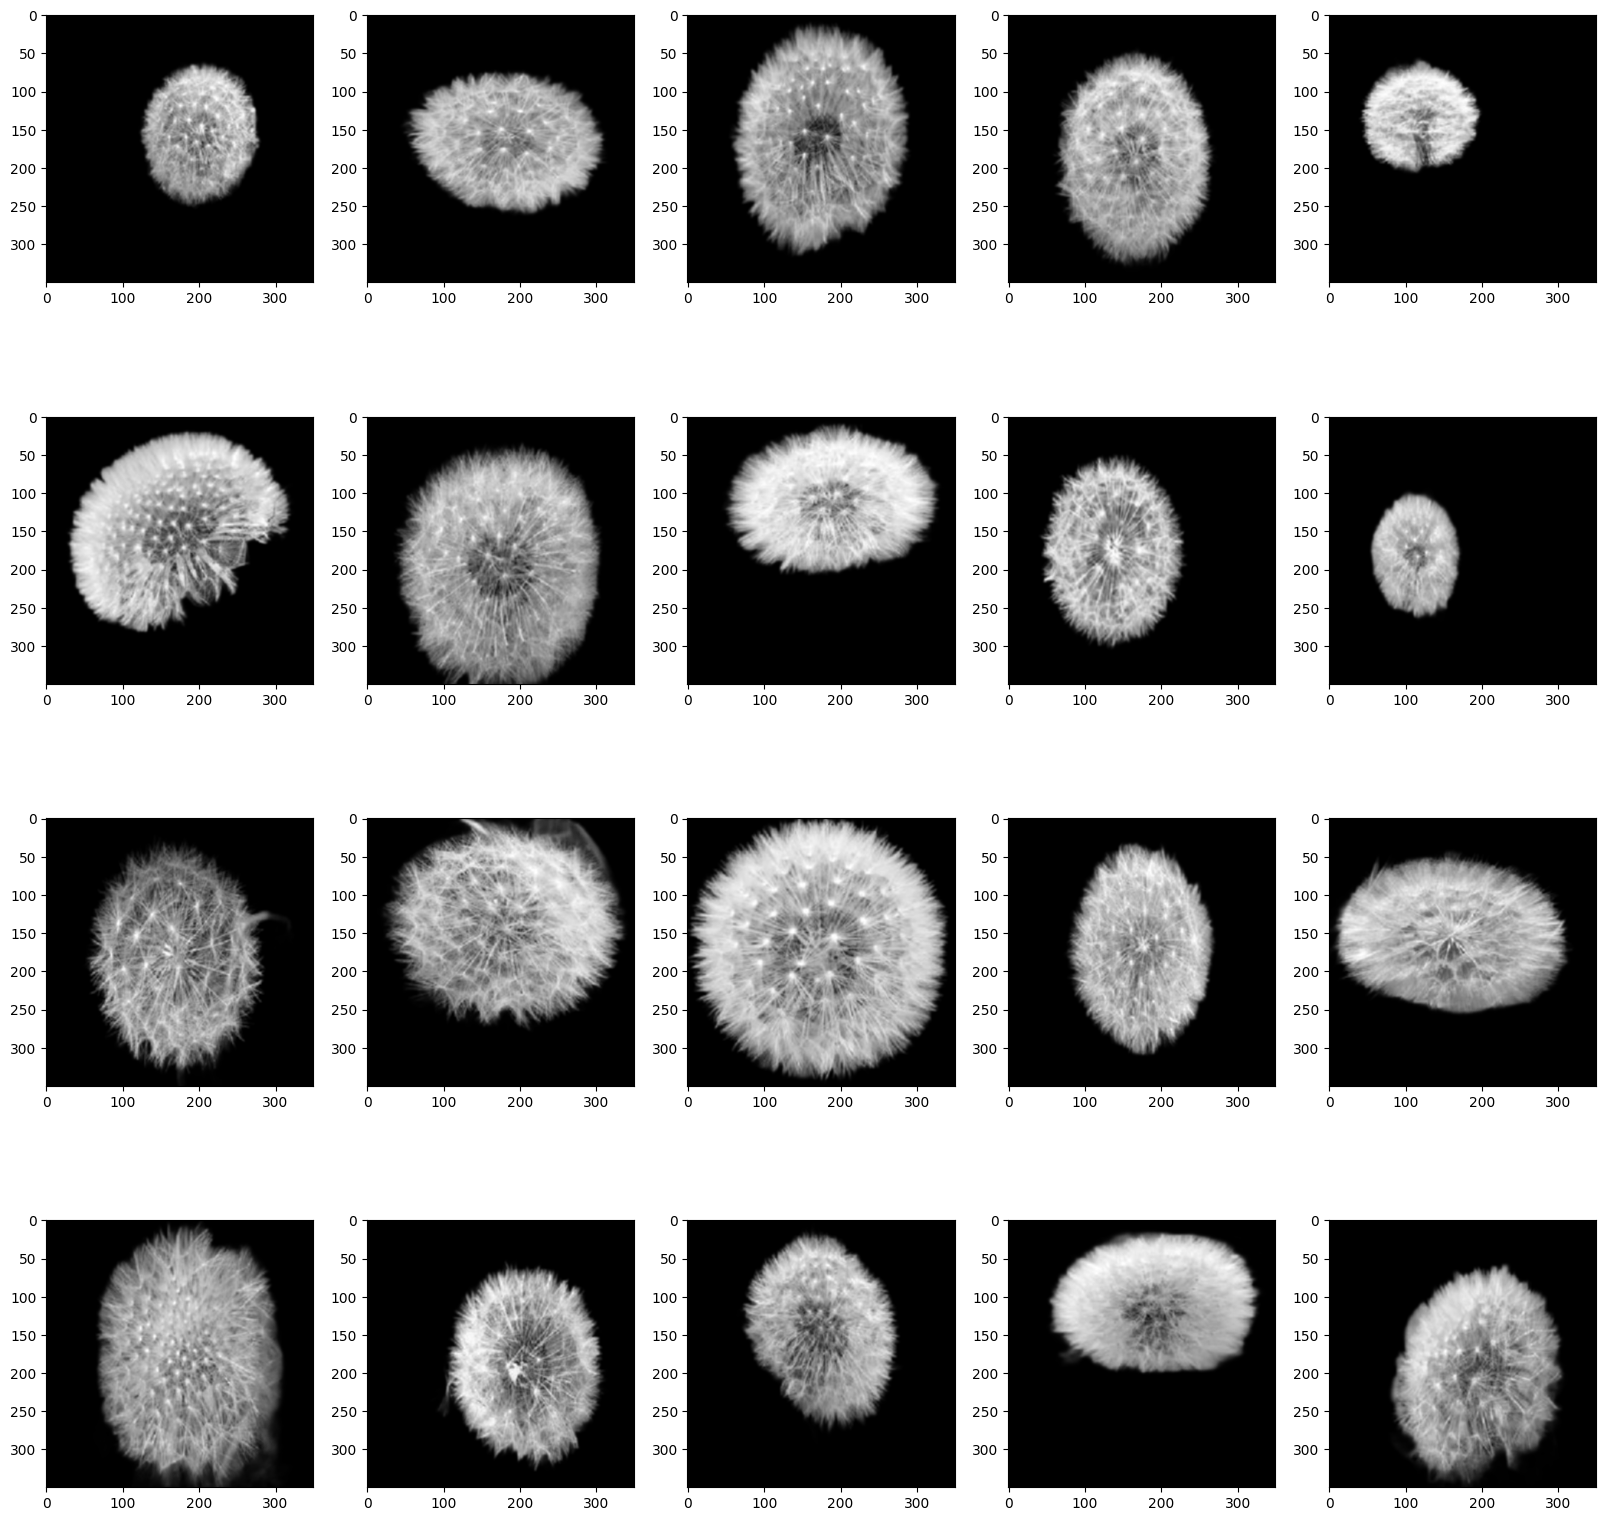

In [211]:
grayData = grayScalingData(removed)
displayImg(4, 5, grayData)

In [212]:
def addPadd(image, kernel):
    i = (kernel.shape[1] - 1) // 2
    j = (kernel.shape[0] - 1) // 2
    left = i
    right = (kernel.shape[1] - 1) - i
    top = j
    bottom = (kernel.shape[0] - 1) - j
    results = np.pad(image, ((top, bottom), (left, right)), mode='edge')
    return results

def convolution(image, kernel):
    paddingImage = addPadd(image, kernel)
    result = np.zeros([image.shape[0], image.shape[1]]).astype(np.uint8)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if paddingImage[i, j] == 0:
                result[i][j] = 0
                continue
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    result[i][j] += paddingImage[i + k, j + l] * kernel[k, l]
    return result

def meanFilterData(data):
    kernel = np.full((3, 3), 1/9)
    mean_data = []
    for i in tqdm(range(len(data))):
        mean_data.append(convolution(data[i], kernel))
    return mean_data


100%|██████████| 300/300 [05:35<00:00,  1.12s/it]


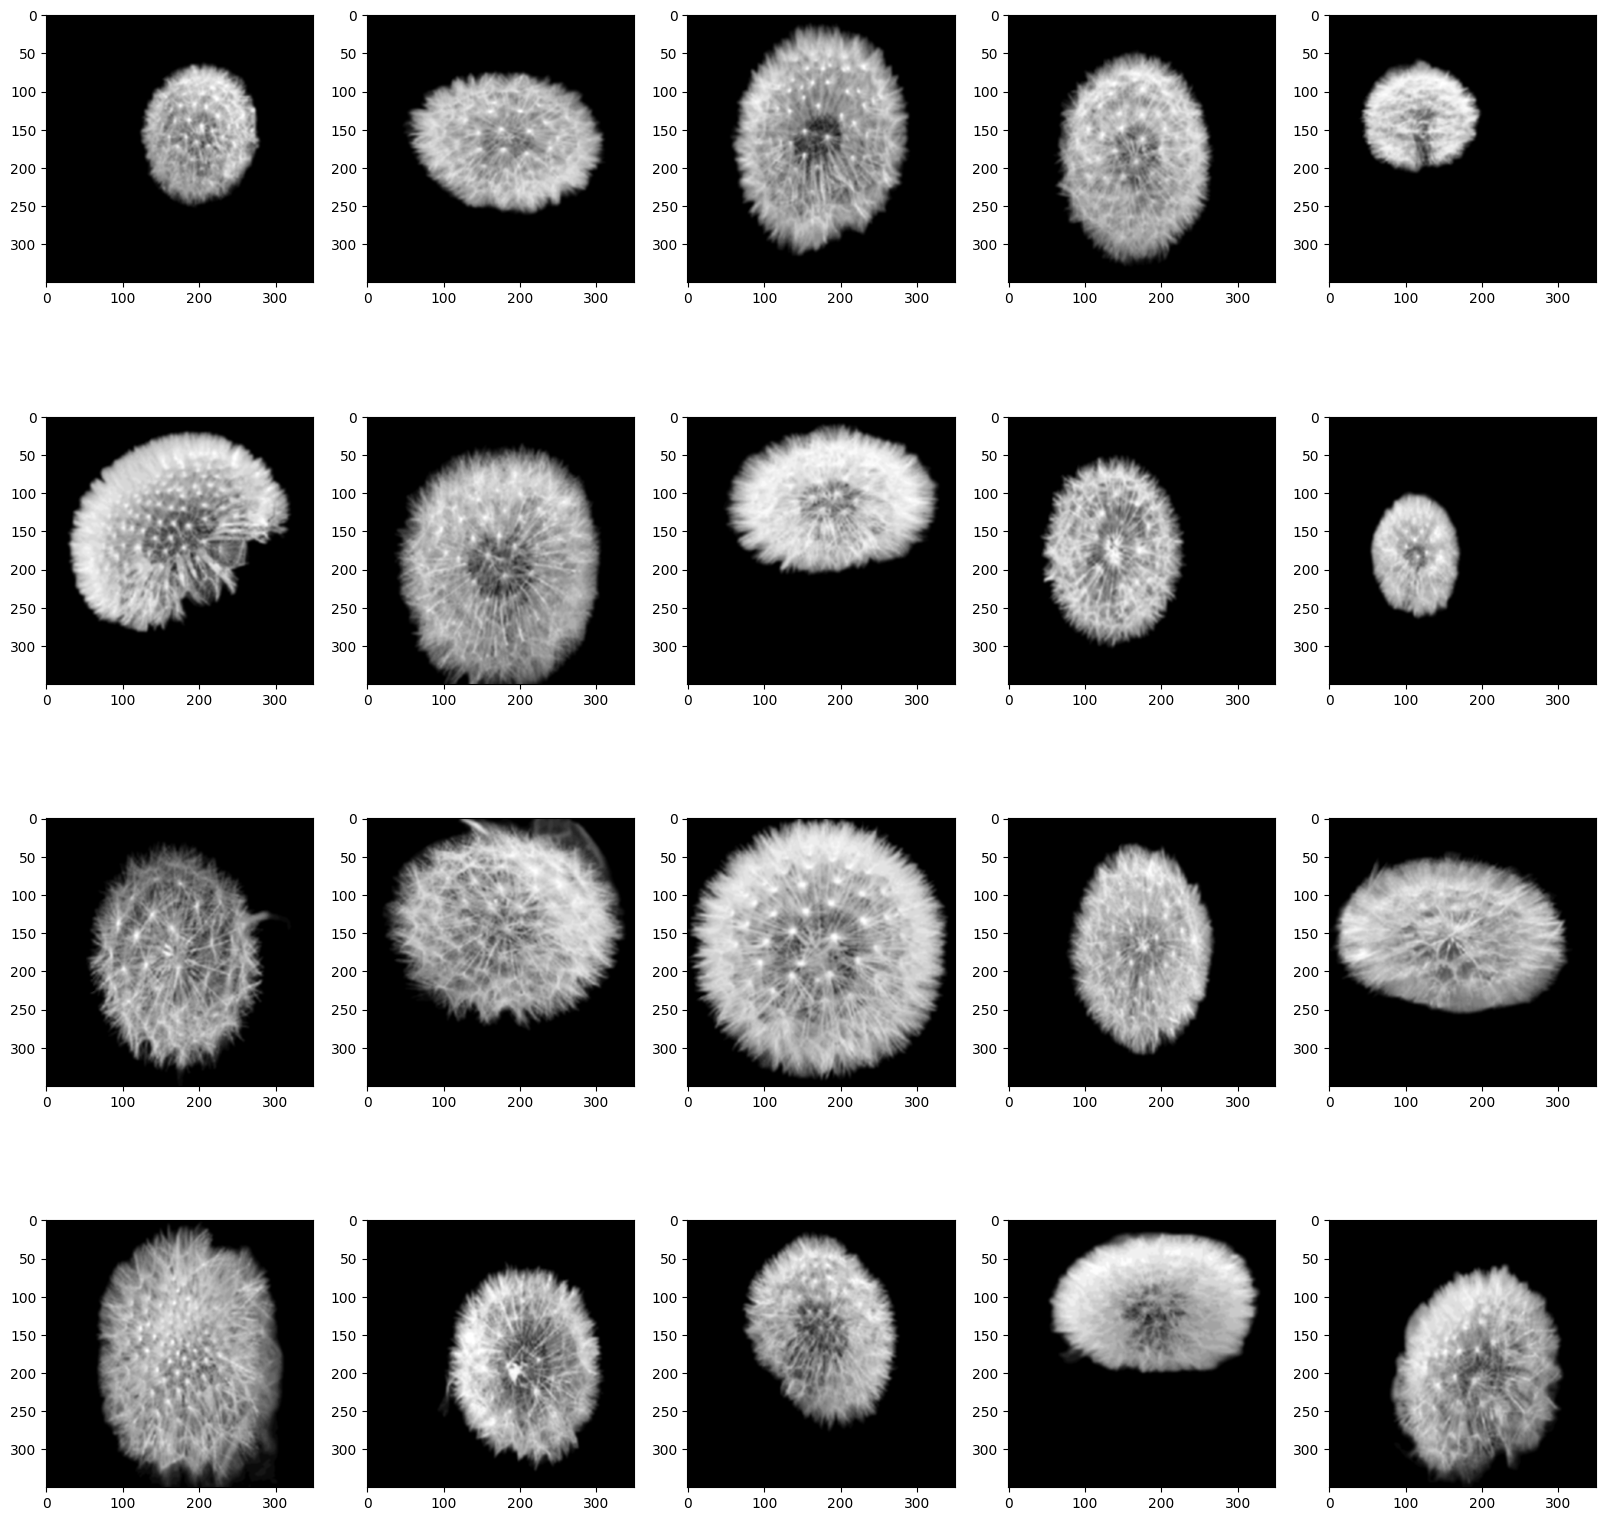

In [213]:
meanData = meanFilterData(grayData)
displayImg(4, 5, meanData)

In [214]:
def findPixel(img,skala=256):
    pixel = np.zeros(skala)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel[int(img[i,j])] =  pixel[int(img[i,j])] + 1
    return pixel

def findProbability(img, pixel,skala=256):
    for i in range(skala):
        pixel[i] = pixel [i] / (img.shape[0] * img.shape[1])
    return pixel

def findCumulative(arr,skala=256):
    for i in range(skala):
        if i != 0:
            arr[i] = arr[i] + arr[i-1]
    return arr

def equalization(img):
    pixel = findPixel(img)
    pixel = findProbability(img,pixel)
    pixel = findCumulative(pixel)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i,j] = pixel[int(img[i,j])] * 255
    return img

def equalizationData(data):
    equalized_data = []
    for i in tqdm(range(len(data))):
        equalized_data.append(equalization(data[i]))
    return equalized_data

100%|██████████| 300/300 [00:52<00:00,  5.67it/s]


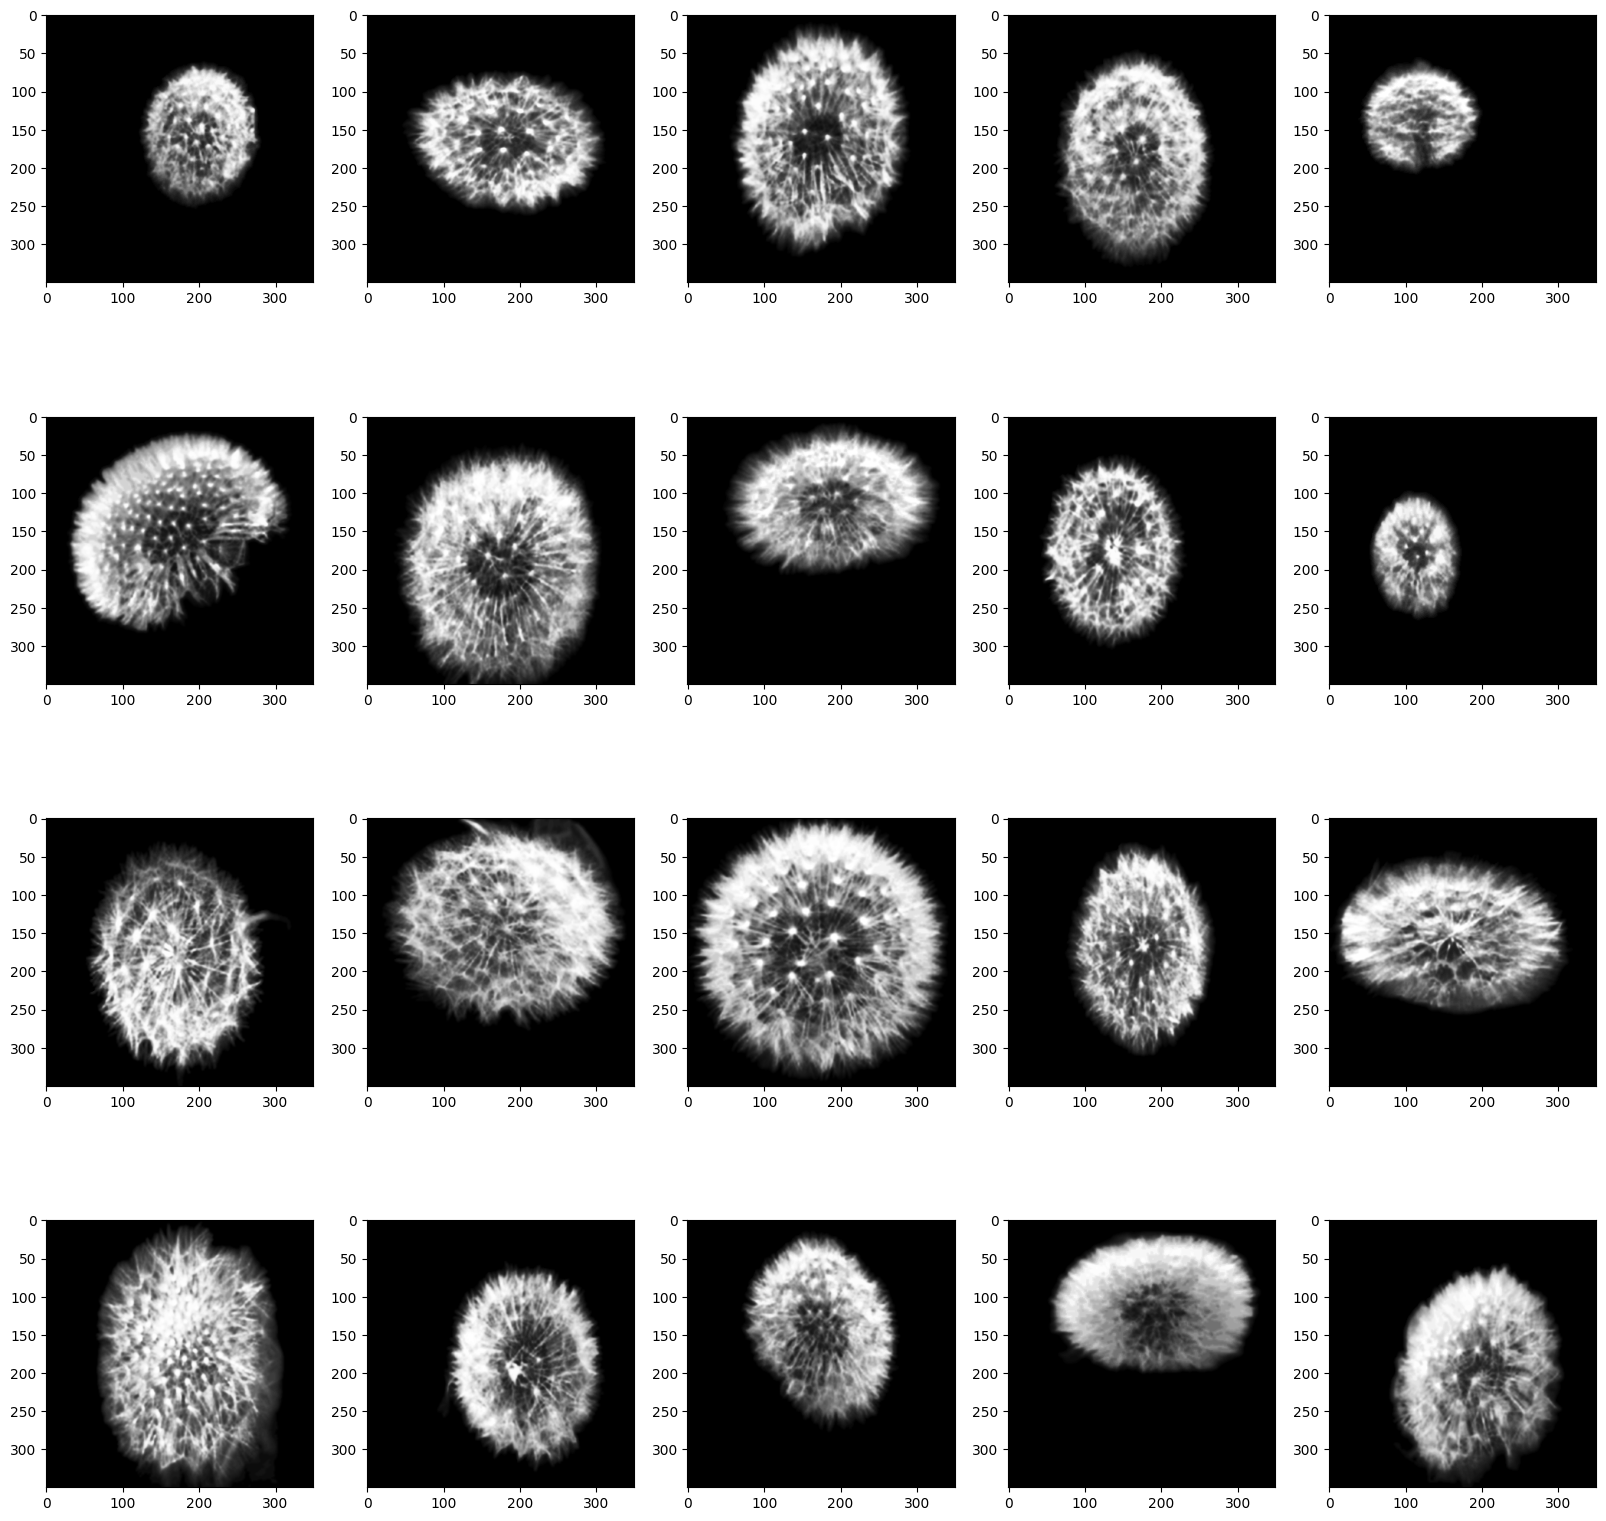

In [215]:
ekualData = equalizationData(meanData)
displayImg(4, 5, ekualData)

In [216]:
def matriksTransformasi(matriks):
    hasil = np.zeros(matriks.shape)
    for i in range(matriks.shape[0]):
        for j in range(matriks.shape[1]):
            hasil[i][j] = matriks[j][i]
    return hasil
def sum(matriks):
    hasil = 0
    for i in range(len(matriks)):
        for j in range(len(matriks[0])):
            hasil += matriks[i][j]
    return hasil

def derajat(img, derajat):
    max = np.max(img)
    temp=np.zeros([max+1,max+1])
    if derajat == 0:
        for i in range (len(img)):
            for j in range (len(img[0])-1):
                temp[img[i,j],img[i,j+1]] += 1
    elif derajat == 45:
        for i in range (len (img)-1):
            for j in range (len (img[0])-1):
                temp[img[i+1,j],img[i,j+1]] += 1
    elif derajat == 90:
        for i in range (len (img)-1):
            for j in range (len (img[0])):
                temp[img[i+1,j],img[i,j]] += 1
    elif derajat == 135:
        for i in range (len (img)-1):
            for j in range (len (img[0])-1):
                temp[img[i,j],img[i+1,j+1]] += 1
    hasil = temp+matriksTransformasi(temp)
    total = sum(hasil)
    for i in range (len (hasil)):
        for j in range (len (hasil)):
            hasil[i,j]/=total
    return hasil

def ekstraksi(image):
    hasil = []
    for img in tqdm(image):
        data = []
        data.append(derajat(img,0))
        data.append(derajat(img,45))
        data.append(derajat(img,90))
        data.append(derajat(img,135))
        hasil.append(data)    
    return hasil

In [222]:
ekstraksiData = ekstraksi(ekualData)

100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


In [218]:
def contrast (data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=data[i,j]*pow(i-j,2)
    return hasil
def dissimilarity(data):  
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=data[i,j]*abs(i-j)
    return hasil
def homogeneity(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=(data[i,j]/(1+pow(i-j,2)))
    return hasil
def energy(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i][j] ** 2
    return hasil

def correlation(data):
    mean_x = 0
    mean_y = 0
    std_x = 0
    std_y = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            mean_x += i * data[i][j]
            mean_y += j * data[i][j]
    for i in range(len(data)):
        for j in range(len(data[0])):
            std_x += (i - mean_x) ** 2 * data[i][j]
            std_y += (j - mean_y) ** 2 * data[i][j]
    std_x = math.sqrt(std_x)
    std_y = math.sqrt(std_y)
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += (i - mean_x) * (j - mean_y) * data[i][j]
    hasil /= std_x * std_y
    return hasil

def entropy(data):
    entropy = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            if data[i][j] > 0.0:
                entropy += -(data[i][j] * math.log(data[i][j]))
    return entropy
def asm(data):
    asm = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            asm += data[i][j] ** 2
    return asm

In [219]:
def ekstraksiFitur(data, path):
    hasil = []
    batas_gambar = len(data)
    for i in tqdm(range(batas_gambar)):
        extracted_data = [path[i]]
        for j in range(len(data[i])):
            contrast_val = contrast(data[i][j])
            extracted_data.append(contrast_val)
        for j in range(len(data[i])):
            dissimilarity_val = dissimilarity(data[i][j])
            extracted_data.append(dissimilarity_val)
        for j in range(len(data[i])):
            homogeneity_val = homogeneity(data[i][j])
            extracted_data.append(homogeneity_val)
        for j in range(len(data[i])):
            energy_val = energy(data[i][j])
            extracted_data.append(energy_val)
        for j in range(len(data[i])):
            correlation_val = correlation(data[i][j])
            extracted_data.append(correlation_val)
        for j in range(len(data[i])):
            asm_val = asm(data[i][j])
            extracted_data.append(asm_val)
            entropy_val = entropy(data[i][j])
            extracted_data.append(entropy_val)
        hasil.append(extracted_data)
    return hasil

In [220]:
angles = ['0', '45', '90', '135']
fiturs = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
headers = ['path']
for fitur in fiturs:
    headers.extend([f'{fitur}_{angle}' for angle in angles])
headers.extend([f'asm_{angle}' for angle in angles])
headers.extend([f'entropy_{angle}' for angle in angles])

In [223]:
hasil = ekstraksiFitur(ekstraksiData, path)
df = pd.DataFrame(hasil, columns=headers)
df

100%|██████████| 300/300 [07:27<00:00,  1.49s/it]


path  contrast_0  contrast_45  contrast_90  contrast_135  \
0    Dendellion    1.499091     2.565562     1.172706      2.532114   
1    Dendellion    4.603880     9.507229     5.853999     10.569650   
2    Dendellion   17.190536    28.821602    10.896865     25.482237   
3    Dendellion    6.801621    12.212461     5.842603     12.061707   
4    Dendellion    0.360671     0.938367     0.647597      0.981946   
..          ...         ...          ...          ...           ...   
295   Sunflower    0.633893     1.035016     0.502906      1.051814   
296   Sunflower   19.438379    38.913786    18.528416     32.606809   
297   Sunflower    5.112534    12.365498     7.348981     11.543945   
298   Sunflower   96.184396   158.957455    82.157323    145.350457   
299   Sunflower   42.519034    60.678287    39.322325     93.089088   

     dissimilarity_0  dissimilarity_45  dissimilarity_90  dissimilarity_135  \
0           0.376635          0.496794          0.334572           0.501342   
1           0.853901          1.249973          0.971330           1.312025   
2           1.933966          2.516334          1.538698           2.393773   
3           1.135194          1.541088          1.049709           1.524667   
4           0.165534          0.276008          0.227131           0.284677   
..               ...               ...               ...                ...   
295         0.160557          0.213939          0.146148           0.218471   
296         1.760982          2.537910          1.694261           2.317616   
297         0.760196          1.235737          0.901040           1.152946   
298         3.922407          5.480965          3.535596           5.210967   
299         2.258928          2.855297          2.132738           3.411384   

     homogeneity_0  ...  correlation_90  correlation_135     asm_0    asm_45  \
0         0.889321  ...        0.995730         0.990801  0.648371  1.682610   
1         0.795815  ...        0.994472         0.990038  0.467186  2.769382   
2         0.667761  ...        0.995870         0.990356  0.301338  4.027220   
3         0.745541  ...        0.996478         0.992742  0.389334  3.330997   
4         0.934909  ...        0.995177         0.992705  0.720092  1.236163   
..             ...  ...             ...              ...       ...       ...   
295       0.950013  ...        0.989165         0.977398  0.803662  0.872391   
296       0.748055  ...        0.987201         0.977516  0.415155  2.963972   
297       0.825480  ...        0.992521         0.988275  0.476831  2.701438   
298       0.625487  ...        0.989615         0.981625  0.118232  4.503133   
299       0.685999  ...        0.988337         0.972421  0.248132  4.252392   

       asm_90   asm_135  entropy_0  entropy_45  entropy_90  entropy_135  
0    0.646550  1.738751   0.648726    1.657299    0.646417     1.739154  
1    0.464087  2.897271   0.466330    2.810444    0.464519     2.907986  
2    0.298970  4.152189   0.301905    3.926509    0.298571     4.138953  
3    0.386919  3.450597   0.389754    3.297974    0.386779     3.446550  
4    0.718267  1.307011   0.719884    1.270138    0.718223     1.309921  
..        ...       ...        ...         ...         ...          ...  
295  0.802522  0.902386   0.804193    0.863297    0.802536     0.904102  
296  0.412374  3.095474   0.415011    2.951270    0.412374     3.065717  
297  0.473010  2.852392   0.475993    2.748502    0.473521     2.834618  
298  0.114149  4.692273   0.119943    4.445115    0.114392     4.682909  
299  0.245340  4.392236   0.248967    4.225221    0.243840     4.456518  

[300 rows x 29 columns]

In [224]:
df.to_csv('after.csv', index=False)

In [245]:
df = pd.read_csv('after.csv')

x = df.drop('path', axis=1)
y = df['path']

In [246]:
pca = PCA(n_components=28)
x_pca = pca.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [247]:
knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)
print('Accuracy:', accuracy_score(y_test, knn_pred))

svm = SVC(kernel='rbf', C=30, gamma='auto')
svm.fit(x_train, y_train)
svm_pred = svm.predict(x_test)
print('Accuracy:', accuracy_score(y_test, svm_pred))

rfc = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, max_depth=50, min_samples_leaf=1, min_samples_split=2, bootstrap=False, criterion='gini')
rfc.fit(x_train, y_train)
rf_pred = rfc.predict(x_test)
print('Accuracy:', accuracy_score(y_test, rf_pred))

Accuracy: 0.8
Accuracy: 0.9166666666666666
Accuracy: 0.9


In [248]:
models = {'KNN': knn_pred, 'SVM': svm_pred, 'Random Forest': rf_pred}
results = {}

for model_name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[model_name] = [accuracy, precision, recall, f1]

results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-Score']).T
print(results_df)

               Accuracy  Precision    Recall  F1-Score
KNN            0.800000   0.808759  0.800000  0.800079
SVM            0.916667   0.915169  0.916667  0.915508
Random Forest  0.900000   0.905500  0.900000  0.900078
